In [1]:
# Import libraires
import cv2
import math
import os, os.path
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

from sklearn.metrics import classification_report
from tensorflow.keras import layers, utils
from tensorflow.keras.applications import EfficientNetB0, vgg16 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

random.seed(42)
print("Tensorflow version:", tf.__version__)
print(f"The number of GPUs: {len(tf.config.list_physical_devices('GPU'))}")

Tensorflow version: 2.6.0
The number of GPUs: 1


# 1. Transfer Learning for Image Classification

It is highly recommended that you complete this project using Keras and Python.

## (a) 
In this problem, we are trying to build a classifier that distinguishes images of 20 bird species. You are provided with text data in twenty folders.

## (b) Data Exploration and Pre-processing

### i. 
Images in each class are given in separate folders. The file `Classes.xlsx` provides the classes assigned to the bird species images in each folder. Therefore, you encode your classes using one-hot encoding and `Classes.xlsx`.

In [2]:
# Read Classes.xlsx and obtain folder name and classes
classes = pd.read_excel('../data/Classes.xlsx', names=['Folder Name', 'Class'])
display(classes)

,Folder Name,Class
0,005.Crested_Auklet,0
1,013.Bobolink,1
2,015.Lazuli_Bunting,2
3,023.Brandt_Cormorant,3
4,040.Olive_sided_Flycatcher,4
5,041.Scissor_tailed_Flycatcher,5
6,067.Anna_Hummingbird,6
7,072.Pomarine_Jaeger,7
8,076.Dark_eyed_Junco,8
9,081.Pied_Kingfisher,9


I will do one-hot encoding after generating new images. This dataframe will serve as a guideline when referring to the name of folders and the name of classes.

### ii.
Randomly select $\lceil 0.7 n_i \rceil$ images from each folder as your training set, $\lceil 0.15 n_i \rceil$ as validation set, and the rest as your test set, where $n_i$ is the number of images in folder $i$ and $\lceil x \rceil$ is the ceiling of $x$.

In [3]:
# This funtion return list of image names in training, validation, and testing set
# With the proportion detetmined as instructed
def data_split(folder):
    # Obtain image names
    path = "../data/images/" + str(folder)
    image_name = [name for name in os.listdir(path)]
    # Obtain number of images in a given folder
    num_image = len(image_name)

    # Caculate number of images for training set, validation set, and test set
    num_train, num_valid = math.ceil(0.7*num_image), math.ceil(0.15*num_image)
    num_test = num_image - num_train - num_valid

    # Use random.sample to obtain 3 sets above
    image_train = random.sample(image_name, num_train)
    image_name = [x for x in image_name if x not in image_train]
    image_valid = random.sample(image_name, num_valid)
    image_name = [x for x in image_name if x not in image_valid]
    image_test = random.sample(image_name, num_test)
    
    return image_train, image_valid, image_test

In [4]:
# Obtain path for training, validation, and testing set
train_path = list()
valid_path = list()
test_path = list()
dir_path = "../data/images/"

for index, row in classes.iterrows():
    folder_name = row['Folder Name']
    split_result = data_split(folder_name)
    for i in split_result[0]:
        train_path.append(str(folder_name) + "/" + i)
    for i in split_result[1]:
        valid_path.append(str(folder_name) + "/" + i)
    for i in split_result[2]:
        test_path.append(str(folder_name) + "/" + i)

In [5]:
print(len(train_path), len(valid_path), len(test_path))

827 178 171


In [6]:
# Take a glance at the path format
print(train_path[0])

005.Crested_Auklet/Crested_Auklet_0074_794949.jpg


### iii.
In order for all the images to have the same size, zero-pad or resize the images in your dataset. This can be done using various tools, including OpenCV.

In [7]:
# Overwrite and format folders even if it exists
splitfolder_path = "../data/images_split"
# Create "../data/images_split" folder
if os.path.exists(splitfolder_path):
        shutil.rmtree(splitfolder_path)
os.makedirs(splitfolder_path)

folder_list = ["training", "validation", "testing"]
for folder in folder_list:
    newfolder_path = splitfolder_path + "/" + folder
    if os.path.exists(newfolder_path):
        shutil.rmtree(newfolder_path)
    os.makedirs(newfolder_path)
    
    # Create class folder in training/validation/testing folder
    for index, row in classes.iterrows():
        folder_name = row['Folder Name']
        class_folder_path = newfolder_path + "/" + folder_name
        if os.path.exists(class_folder_path):
            shutil.rmtree(class_folder_path)
        os.makedirs(class_folder_path)

The above code is to make sure that images will are saved into correct folder with folder names matching to image class namae.

In [8]:
# Resize for training/validation/testing set and save images
# according to their class
for path in train_path:
    img = cv2.imread(dir_path + path)
    img_pad = cv2.resize(img, (224, 224))
    cv2.imwrite("../data/images_split/training/" + path, img_pad)

# Resize for validation set
for path in valid_path:
    img = cv2.imread(dir_path + path)
    img_pad = cv2.resize(img, (224, 224))
    cv2.imwrite("../data/images_split/validation/" + path, img_pad)

# Resize for testing set
for path in test_path:
    img = cv2.imread(dir_path + path)
    img_pad = cv2.resize(img, (224, 224))
    cv2.imwrite("../data/images_split/testing/" + path, img_pad)

## (c) Transfer Learning

### i.
When dealing with classification of relatively small image datasets, deep networks may not perform very well because of not having enough data to train them. In such cases, one usually uses *transfer learning*, which uses deep learning models that are trained on very large datasets such as `ImageNet` as feature extractors. The idea is that such deep networks have learned to extract meaningful features from an image using their layers, and those features can be used in learning other tasks. In order to do that, usually the last layer or the last few layers of the pre-trained network are removed, and the response of the layer before the removed layers to the images in the new dataset is used as a feature vector to train one more multiple replacement layers. The dataset in this task has only around 50-60 images per class. Given that we have 20 classes, training a deep network with such a small dataset may not yield desirable results. In this project, you will use pre-trained models `EfficientNetB0` and `VGG16`. For both pre-trained networks, you will only train the last fully connected layer, and will *freeze* all layers before them (i.e. we do not change their parameters during training) and use the outputs of the penultimate layer in the original pre-trained model as the features extracted from each image.

### ii. 
To perform empirical regularization, crop, randomly zoom, rotate, flip, contrast, and translate images in your training set for image

In [9]:
# Crop image
def crop(img, y, x, h, w):
    """
    The first dimension is the number of rows or the height of the image
    The second dimension is the number of columns or the width of the image
    """
    cropped_img = img[y:y+h, x:x+w]
    return cropped_img


# Zoom image
def zoom(img, zoom_factor):
    h, w, _ = [zoom_factor*i for i in img.shape]
    cx, cy = w/2, h/2
    
    img = cv2.resize(img, (0, 0), fx=zoom_factor, fy=zoom_factor)
    img = img[int(round(cy - h/zoom_factor*0.5)) : int(round(cy + h/zoom_factor*0.5)),
              int(round(cx - w/zoom_factor*0.5)) : int(round(cx + w/zoom_factor*0.5)),
              :]
    return img


# Rotate image
def rotate(img, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result


# Filp image
def flip(img, flip_factor):
    """
    flip_factor:
        = 0, for flipping the image around the x-axis (vertical flipping);
        > 0 for flipping around the y-axis (horizontal flipping);
        < 0 for flipping around both axes.
    """
    return cv2.flip(img, flip_factor)


# Contrast image
def contrast(img, alpha):
    """
    alpha: (0.0,  inf) with 1.0 leaving the contrast as is
    """
    return cv2.addWeighted(img, alpha, img, 0, 0, 0)


# Translate image
def translate(img, tx, ty):
    """
    tx < 0 shifts the image to the left
    tx > 0 shifts the image to the right
    ty < 0 shifts the image up 
    ty > 0 shifts the image down
    """
    # Get the width and height of the image
    height, width = image.shape[:2]
    # Create translation matrix using tx and ty
    translation_matrix = np.array([
        [1, 0, tx],
        [0, 1, ty]
    ], dtype=np.float32)
    return cv2.warpAffine(img, M=translation_matrix, dsize=(width, height))


# Save image
def save_img(img, img_class, img_name, action):
    return cv2.imwrite("../data/images_split/training/" 
                       + img_class + "/" 
                       + action 
                       + img_name, img)

We perform empirical regularization (6 actions) on each image in the trainig set. Then we save images according to action name along with the original image.

In [10]:
# Perform empirical regularization on the training set
# Obtain image name in the training folder
img_name = list()
for path in train_path:
    img_name.append(path)
    
# Generate and save new images
for name in img_name:
    path = "../data/images_split/training/" + name
    image = cv2.imread(path)
    
    img_class = name.split('/')[0]
    img_file_name = name.split('/')[1]
    
    # Crop image by randomly generated starting points, height, and width
    y, x = random.randint(20, 120), random.randint(20, 120)
    h, w = 100, 100
    image_crop = crop(image, y, x, h, w)
    # Matching cropped images in training set
    image_crop = cv2.resize(image_crop, (224, 224))
    save_img(image_crop, img_class, img_file_name, 'crop_')
    
    # Zoom image by randomly generated zoom factor
    zoom_factor = random.uniform(1, 3)
    image_zoom = zoom(image, zoom_factor)
    # Matching zoom images in training set
    save_img(image_zoom, img_class, img_file_name, 'zoom_')
    
    # Rotate image by randomly generated angle
    angle = random.randint(0, 360)
    image_rotate = rotate(image, angle)
    save_img(image_rotate, img_class, img_file_name, 'rotate_')
    
    # Filp image by randomly selecting flip factor
    flip_factor = random.choice([-1, 0, 1])
    imag_flip = flip(image, flip_factor)
    save_img(imag_flip, img_class, img_file_name, 'flip_')
    
    # Contrast image by randomly generated alpha
    alpha = random.uniform(0.5, 2)
    image_contrast = contrast(image, alpha)
    save_img(image_contrast, img_class, img_file_name, 'contrast_')
    
    # Translate image by randomly generated tx and ty for translation matrix
    tx, ty = random.randint(-100, 10), random.randint(-100, 100)
    image_translate = translate(image, tx, ty)
    save_img(image_translate, img_class, img_file_name, 'translate_')

After performing empirical regularization, we want to load images in and label them for training, validating, and testing.

In [11]:
train_ds = utils.image_dataset_from_directory(
    directory='../data/images_split/training/',
    labels='inferred',
    label_mode='categorical',
    batch_size=5,
    image_size=(224, 224), 
    shuffle=True)

Found 5789 files belonging to 20 classes.


In [12]:
validation_ds = utils.image_dataset_from_directory(
    directory='../data/images_split/validation/',
    labels='inferred',
    label_mode='categorical',
    batch_size=5,
    image_size=(224, 224),
    shuffle=False)

Found 178 files belonging to 20 classes.


In [13]:
test_ds = utils.image_dataset_from_directory(
    directory='../data/images_split/testing/',
    labels='inferred',
    label_mode='categorical',
    batch_size=5,
    image_size=(224, 224),
    shuffle=False)

Found 171 files belonging to 20 classes.


The number looks correct here as the number of validation and testing images match with what we have earlier. The number of training images is calculated by $827 \cdot (1+6) = 5789$ where for each original image we have six more generated images.

In [14]:
# Insepect data
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(5, 224, 224, 3)
(5, 20)


The dimensions of batched images and labels look good. We can start working on the models.

### iii.
Use ReLU activation functions in the last layer and a softmax layer, along with batch normalization and a dropout rate of 20% as well as ADAM optimizer. Use multinomial cross entropy loss. You can try any batch size, but a batch size of 5 seems reasonable.

#### Construct EfficientNetB0

In [15]:
# Define model according to the instruction
EfficientNet_base = EfficientNetB0(include_top=False, weights="imagenet")
# Freeze the pretrained weights
EfficientNet_base.trainable = False

top_dropout_rate = 0.2

# Rebuild some layers
inputs = layers.Input(shape = (224,224,3), name='inputLayer')  # input matching image size

x = EfficientNet_base(inputs)

x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
x = layers.BatchNormalization()(x)  # batch normalization

x = layers.Dense(1280, activation="relu", name='reludenseLayer1')(x)  # ReLU layer
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)  # Dropout rate of 20% for input

x = layers.Dense(160, activation="relu", name='reludenseLayer2')(x)  # ReLU layer

x = layers.Dense(20, activation="relu", name='reludenseLayer3')(x)  # ReLU layer

outputs = layers.Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x)

EfficientNet = tf.keras.Model(inputs, outputs, name = "EfficientNet")
EfficientNet.summary()

Model: "EfficientNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputLayer (InputLayer)      [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 1280)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
reludenseLayer1 (Dense)      (None, 1280)              1639680   
_________________________________________________________________
top_dropout (Dropout)        (None, 1280)              0         
_________________________________________________________________
reludenseLayer2 (Dense)      (None, 160)              

#### Construct VGG16

In [16]:
# Define model according to the instruction
VGG_base = vgg16.VGG16(include_top=False, weights="imagenet")
# Freeze the pretrained weights
VGG_base.trainable = False

top_dropout_rate = 0.2

# Rebuild some layers
inputs = layers.Input(shape = (224,224,3), name='inputLayer')  # input matching image size
x = VGG_base(inputs)

x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
x = layers.BatchNormalization()(x)  # batch normalization

x = layers.Dense(512, activation="relu", name='reludenseLayer1')(x)  # ReLU layer
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)  #  Dropout rate of 20% for input

x = layers.Dense(128, activation="relu", name='reludenseLayer2')(x)  # ReLU layer

x = layers.Dense(20, activation="relu", name='reludenseLayer3')(x)  # ReLU layer

outputs = layers.Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x)

VGG = tf.keras.Model(inputs, outputs, name = "VGG")
VGG.summary()

Model: "VGG"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputLayer (InputLayer)      [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
reludenseLayer1 (Dense)      (None, 512)               262656    
_________________________________________________________________
top_dropout (Dropout)        (None, 512)               0         
_________________________________________________________________
reludenseLayer2 (Dense)      (None, 128)               65664   

In [17]:
# Function to plot training and validation errors vs. epochs
def plot_hist(hist):
    plt.figure(figsize=(8, 6), dpi=80)
    plt.plot([1 - i for i in hist.history["accuracy"]])
    plt.plot([1 - i for i in hist.history["val_accuracy"]])
    plt.title("Training and Validation Errors vs. Epochs")
    plt.ylabel("Error")
    plt.xlabel("Epochs")
    plt.legend(["train", "validation"], loc="upper right")
    plt.show()

### iv.
Train the networks (`EfficientNetB0` and `VGG16`) for at least 50 epochs (preferably 100 epochs) and perform early stopping using the validation set. Keep the network parameters that have the lowest validation error. Plot the training and validation errors vs. epochs.

#### EfficientNetB0

In [18]:
%%time
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# Save model with lowest validation error
filepath = "EfficientNet_best.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=0, 
                             save_best_only=True,
                             mode='min')

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                             patience=50, 
                                             verbose=1, 
                                             restore_best_weights=True)

EfficientNet.compile(loss = "categorical_crossentropy",
                     optimizer = optimizer,
                     metrics = ["accuracy"])

epochs = 100
EfficientNet_hist = EfficientNet.fit(train_ds, epochs=epochs, validation_data=validation_ds, 
                                     callbacks=[checkpoint, earlystop], verbose=2)

Epoch 1/100
1158/1158 - 20s - loss: 1.1182 - accuracy: 0.6735 - val_loss: 0.2234 - val_accuracy: 0.9157


C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/100
1158/1158 - 13s - loss: 0.4314 - accuracy: 0.8673 - val_loss: 0.2473 - val_accuracy: 0.9270
Epoch 3/100
1158/1158 - 13s - loss: 0.2738 - accuracy: 0.9150 - val_loss: 0.2278 - val_accuracy: 0.9213
Epoch 4/100
1158/1158 - 13s - loss: 0.2084 - accuracy: 0.9326 - val_loss: 0.3400 - val_accuracy: 0.9157
Epoch 5/100
1158/1158 - 13s - loss: 0.1805 - accuracy: 0.9404 - val_loss: 0.2928 - val_accuracy: 0.9382
Epoch 6/100
1158/1158 - 13s - loss: 0.1491 - accuracy: 0.9525 - val_loss: 0.3770 - val_accuracy: 0.9213
Epoch 7/100
1158/1158 - 12s - loss: 0.1307 - accuracy: 0.9570 - val_loss: 0.2759 - val_accuracy: 0.9326
Epoch 8/100
1158/1158 - 12s - loss: 0.1219 - accuracy: 0.9591 - val_loss: 0.2733 - val_accuracy: 0.9326
Epoch 9/100
1158/1158 - 13s - loss: 0.1083 - accuracy: 0.9632 - val_loss: 0.2504 - val_accuracy: 0.9326
Epoch 10/100
1158/1158 - 13s - loss: 0.0885 - accuracy: 0.9710 - val_loss: 0.2727 - val_accuracy: 0.9213
Epoch 11/100
1158/1158 - 13s - loss: 0.0882 - accuracy: 0.9705 

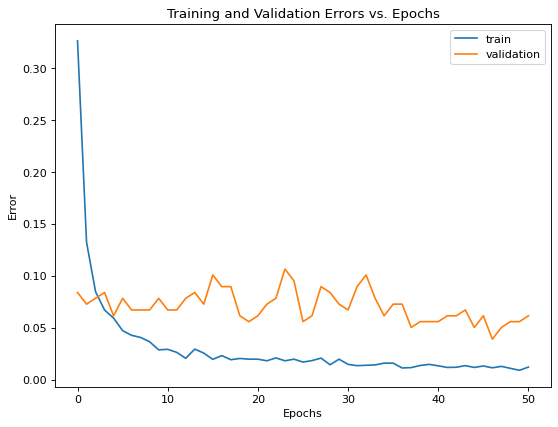

In [19]:
plot_hist(EfficientNet_hist)

We see that the training error decreases rapidly after the first a few epochs, and it remains low through out the training. The validation error stays in the range from 0.05 to 0.15 and is larger than the training error after the first few epochs. Though we set 100 epochs for training the `EfficientNetB0` model, the training process is terminated by the early stopping at epoch = 51 as we are monitoring on validation error.

#### VGG16

In [20]:
%%time
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# Save model with lowest validation error
filepath = 'VGG_best.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=0, 
                             save_best_only=True,
                             mode='min')

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                             patience=50, 
                                             verbose=1, 
                                             restore_best_weights=True)

VGG.compile(loss = "categorical_crossentropy",
                     optimizer = optimizer,
                     metrics = ["accuracy"])

epochs = 100
VGG_hist = VGG.fit(train_ds, epochs=epochs, validation_data=validation_ds, 
                   callbacks=[checkpoint, earlystop], verbose=2)

Epoch 1/100
1158/1158 - 14s - loss: 2.4570 - accuracy: 0.2885 - val_loss: 1.5298 - val_accuracy: 0.5955
Epoch 2/100
1158/1158 - 12s - loss: 1.5544 - accuracy: 0.5763 - val_loss: 1.2015 - val_accuracy: 0.7022
Epoch 3/100
1158/1158 - 12s - loss: 1.2633 - accuracy: 0.6459 - val_loss: 1.0846 - val_accuracy: 0.7191
Epoch 4/100
1158/1158 - 12s - loss: 1.1314 - accuracy: 0.6877 - val_loss: 1.0299 - val_accuracy: 0.7135
Epoch 5/100
1158/1158 - 12s - loss: 1.0005 - accuracy: 0.7217 - val_loss: 1.0146 - val_accuracy: 0.7360
Epoch 6/100
1158/1158 - 12s - loss: 0.9314 - accuracy: 0.7416 - val_loss: 1.0097 - val_accuracy: 0.7303
Epoch 7/100
1158/1158 - 12s - loss: 0.8703 - accuracy: 0.7547 - val_loss: 0.9892 - val_accuracy: 0.7247
Epoch 8/100
1158/1158 - 12s - loss: 0.8149 - accuracy: 0.7722 - val_loss: 0.9933 - val_accuracy: 0.7247
Epoch 9/100
1158/1158 - 12s - loss: 0.7880 - accuracy: 0.7803 - val_loss: 0.9886 - val_accuracy: 0.7472
Epoch 10/100
1158/1158 - 12s - loss: 0.7339 - accuracy: 0.7937 -

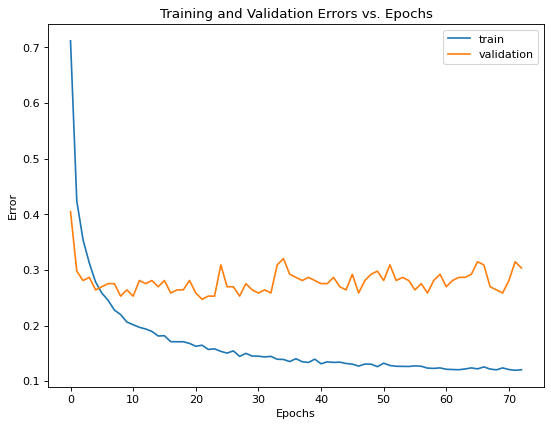

In [21]:
plot_hist(VGG_hist)

We see that the training stays low after first 10-20 epochs. It stays low in the later training process. The validation error stays around 0.3 and is larger than the training error. Though we set 100 epochs for training the `VGG16` model, the training process is terminated by the early stopping.

### v.
Report Precision, Recall, and F1 score for your model. Remember that this is a multi-class classification problem.

#### EfficientNet Report

In [22]:
# Obtain true labels from data set
y_true = np.concatenate([y for x, y in test_ds], axis=0)
print(y_true.shape)

(171, 20)


In [23]:
# Make prediction using EfficientNet
y_pred_EN = EfficientNet.predict(test_ds)
y_pred_EN_categorical = utils.to_categorical(np.argmax(y_pred_EN, axis=1), 20)
print(y_pred_EN_categorical.shape)

(171, 20)


In [24]:
# Report Precision, Recall, and F1 score for EfficientNet
print(classification_report(y_true, y_pred_EN_categorical))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         9
           2       1.00      0.88      0.93         8
           3       0.71      0.62      0.67         8
           4       0.71      0.56      0.63         9
           5       0.75      1.00      0.86         9
           6       0.90      1.00      0.95         9
           7       0.82      1.00      0.90         9
           8       0.90      1.00      0.95         9
           9       1.00      1.00      1.00         9
          10       1.00      0.89      0.94         9
          11       0.89      0.89      0.89         9
          12       1.00      0.67      0.80         9
          13       0.80      0.89      0.84         9
          14       0.82      1.00      0.90         9
          15       0.86      0.75      0.80         8
          16       1.00      1.00      1.00         8
          17       1.00    

We see that the `EfficientNet` model does a good job overall. While we can still recognize that it does not perform very well on class 3 and 4, the overall result should be considered as acceptable.

#### VGG Report

In [25]:
# Prediction for VGG
y_pred_VGG = VGG.predict(test_ds)
y_pred_VGG_categorical = utils.to_categorical(np.argmax(y_pred_VGG, axis=1), 20)
print(y_pred_VGG_categorical.shape)

(171, 20)


In [26]:
print(classification_report(y_true, y_pred_VGG_categorical))

              precision    recall  f1-score   support

           0       0.45      0.83      0.59         6
           1       0.90      1.00      0.95         9
           2       0.83      0.62      0.71         8
           3       0.80      1.00      0.89         8
           4       0.00      0.00      0.00         9
           5       0.86      0.67      0.75         9
           6       0.75      1.00      0.86         9
           7       0.64      0.78      0.70         9
           8       0.50      0.56      0.53         9
           9       1.00      1.00      1.00         9
          10       0.58      0.78      0.67         9
          11       1.00      1.00      1.00         9
          12       0.86      0.67      0.75         9
          13       0.58      0.78      0.67         9
          14       0.75      0.67      0.71         9
          15       0.58      0.88      0.70         8
          16       1.00      1.00      1.00         8
          17       0.50    

C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The `VGG16` model obtains overall precision, recall, and F1 score that are slightly lower than the previous model, especially for class 0, 2, 4, 8, 17, and 18. It performs well in general.

# Reference

[Adding borders to your images](https://docs.opencv.org/3.4/dc/da3/tutorial_copyMakeBorder.html)

[Hands-on Transfer Learning with Keras and the VGG16 Model](https://www.learndatasci.com/tutorials/hands-on-transfer-learning-keras/)

[Image classification via fine-tuning with EfficientNet](https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/)

[Image Classification Transfer Learning and Fine Tuning using TensorFlow](https://towardsdatascience.com/image-classification-transfer-learning-and-fine-tuning-using-tensorflow-a791baf9dbf3)

[Image data loading](https://keras.io/api/data_loading/image/#:~:text=batch_size%3A%20Size%20of%20the%20batches,as%20(height%2C%20width)%20.)

[sklearn.metrics.classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)

[sklearn.preprocessing.OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)

[tf.keras.applications.efficientnet.EfficientNetB0](https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet/EfficientNetB0)


[tf.keras.utils.image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory)